The adaptive clustering works quite well on the simulated data (note that p=2 for all simulated data), which indicates the implementation of this algorithm should be OK. However, this approach does not work well on the real data (p>5 for most of the data). 

I noticed two possible reasons: 

1. The weight matrix fails to initialize properly for relative large p (most of the weight matrix values are initialized to 1). The paper proposed to set n0=2p+2 and then set h accordingly. This may be too large for relative large p. 

2. Even with very small lambda such as 0.0001, the weight matrix still grows (some values become 1) in the large p setting. This is either related to bad initialization or the test statistic they use.  The test statistic follows a Chi-square distribution under the null and the Chi-square test needs the degree of freedom in order to calculate the p value. However, no such information was considered in their algorithm. 

This notebook was aimed to investigate those problems. 


It seems to me the adaptive clustering does not work quite well when p is relatively large. It fails to initilize properly and fails to generate proper h_k sequence. I think this is because the distance between two points are equally far way in high dimension. 

## Install packages

In [105]:
sys.path.append('../kmean_clustering')
from kmean_clustering import adaptive_cluster

In [106]:
import sys
import pandas as pd
import numpy as np
#from kmean_clustering import kmean_clustering as kc
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

In [107]:
print('Python')
print(sys.version)
print('Numpy')
print(np.__version__)
print('Pandas')
print(pd.__version__)

Python
3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy
1.12.1
Pandas
0.20.1


In [108]:
def plot_weight_matrix(weight_matrix):
    plt.imshow(weight_matrix)
    plt.show()

## Load data

In [109]:
cluster_data = {}
sim_data_names = ['Aggregation',  'Compound',  'D31',  'flame', 'jain',  'pathbased',  'R15',  'spiral']

for dn in sim_data_names:
    raw_data = pd.read_csv('../data/%s.txt' % dn,sep='\t',header=None)
    label = raw_data.iloc[:,2].values
    data   = raw_data.drop(2,axis=1).values
    cluster_data[dn] = (data,label)
    #print(dn,'#true clusters',cluster_data[dn].iloc[:,2].nunique())
    del(raw_data,data,label)
    #cluster_data[dn].head()

In [110]:
from sklearn.preprocessing import MinMaxScaler

#cluster_data = {}

### data were downloaded from https://github.com/deric/clustering-benchmark/tree/master/src/main/resources/datasets/real-world
### except the leaves data

real_data_names = ['letter','wine','glass','thyroid','yeast','iris','leaves','wdbc']

## letter 16 + 1
raw_data = pd.read_csv('../data/letter.txt',header=None)
data  = raw_data.drop(16,axis=1).values
label = pd.Categorical(raw_data.iloc[:,16]).codes
cluster_data['letter'] = (data,label)
del(raw_data,data,label)

## wine 1 + 13
raw_data = pd.read_csv('../data/wine.txt',header=None)
data  = raw_data.drop(0,axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
label = pd.Categorical(raw_data.iloc[:,0]).codes
cluster_data['wine'] = (data,label)
del(raw_data,data,label)

## glass 9 + 1
raw_data = pd.read_csv('../data/glass.txt',header=None)
data  = raw_data.drop(9,axis=1).values
label = pd.Categorical(raw_data.iloc[:,9]).codes
cluster_data['glass'] = (data,label)
del(raw_data,data,label)

## thyroid 5 + 1
raw_data = pd.read_csv('../data/thyroid.txt',header=None)
data  = raw_data.drop(5,axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
### merge class 2 and 3 into one class
label = pd.Categorical(raw_data.iloc[:,5].replace(3,2)).codes.copy()
cluster_data['thyroid'] = (data,label)
del(raw_data,data,label)


## yeast 1 + 8 + 1
raw_data = pd.read_csv('../data/yeast.txt',sep='\s+',header=None)
data  = raw_data.drop([0,9],axis=1).values
label = pd.Categorical(raw_data.iloc[:,9]).codes.copy()
cluster_data['yeast'] = (data,label)
del(raw_data,data,label)

## iris 4 + 1
raw_data = pd.read_csv('../data/iris.txt',header=None)
data  = raw_data.drop(4,axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
label = pd.Categorical(raw_data.iloc[:,4]).codes.copy()
cluster_data['iris'] = (data,label)
del(raw_data,data,label)

## wdbc 1 + 1 + 30
raw_data = pd.read_csv('../data/wdbc.txt',header=None)
data  = raw_data.drop([0,1],axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
label = pd.Categorical(raw_data.iloc[:,1]).codes.copy()
cluster_data['wdbc'] = (data,label)
del(raw_data,data,label)


## leaves 1 + 1 + 30
raw_data = pd.read_csv('../data/leaves.txt', sep='\s+',header=None)
data  = raw_data.values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
raw_data_label = pd.read_csv('../data/leaves_labels.txt',header=None)
label = pd.Categorical(raw_data_label.iloc[:,0]).codes.copy()
cluster_data['leaves'] = (data,label)
del(raw_data,data,label,raw_data_label)

In [111]:
data_names = real_data_names + sim_data_names
for dn in data_names:
    print('true clusters',dn,len(np.unique(cluster_data[dn][1])),'shape',cluster_data[dn][0].shape)

true clusters letter 26 shape (20000, 16)
true clusters wine 3 shape (178, 13)
true clusters glass 6 shape (214, 9)
true clusters thyroid 2 shape (215, 5)
true clusters yeast 10 shape (1484, 8)
true clusters iris 3 shape (150, 4)
true clusters leaves 100 shape (1600, 64)
true clusters wdbc 2 shape (569, 30)
true clusters Aggregation 7 shape (788, 2)
true clusters Compound 6 shape (399, 2)
true clusters D31 31 shape (3100, 2)
true clusters flame 2 shape (240, 2)
true clusters jain 2 shape (373, 2)
true clusters pathbased 3 shape (300, 2)
true clusters R15 15 shape (600, 2)
true clusters spiral 3 shape (312, 2)


### Weight matrix initialization

In [91]:
### wrap the initialization step into a function
### note that the initialization step only needs distance matrix and n0
### n0 = 2p+2 by the original paper

import scipy
from  scipy.spatial.distance import pdist,squareform,cdist
from scipy.spatial import distance_matrix

def initialization(data,n0=None):
    (n_points,n_features) = data.shape
    print('Calculate distance matrix',end=', ')
    distance_matrix = scipy.spatial.distance.cdist(data, data, 'euclidean')
    print('done')
    weight_matrix = np.zeros(shape=(n_points,n_points))
    print('Sort distance matrix',end=', ')
    sorted_distance_idx_matrix = np.argsort(distance_matrix,axis=1)
    sorted_distance_matrix = np.sort(distance_matrix,axis=1)
    print('done')
    if n0 is None:
        n0 = 2*n_features+2
    ### h0 is the the radius such that the point has n0 neighbors
    print('Initialize weight matrix',end=', ')
    h0 = sorted_distance_matrix[:,n0]
    #max_h0 = np.reshape([np.maximum(h0[i],h0[j]) for i in range(n_points) for j in range(n_points)],newshape=(n_points,n_points))
    #weight_matrix = (distance_matrix <= max_h0).astype('int')
    ## faster version
    h0_matrix = np.tile(h0, (n_points, 1))
    h0_matrix_T = h0_matrix.T
    weight_matrix = (distance_matrix<=np.maximum(h0_matrix,h0_matrix_T)).astype('int')
    print('done')
    plot_weight_matrix(weight_matrix)
    return(weight_matrix)

Aggregation (788, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


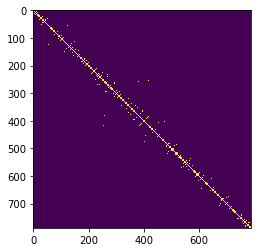

Compound (399, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


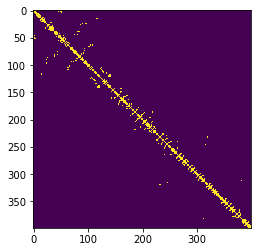

D31 (3100, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


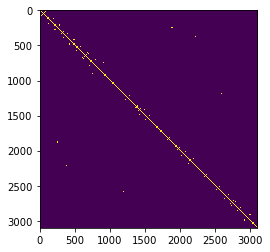

flame (240, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


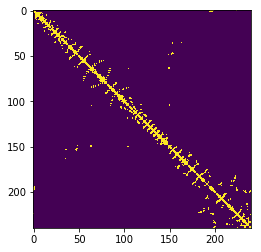

jain (373, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


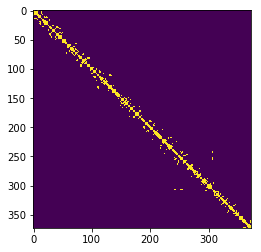

pathbased (300, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


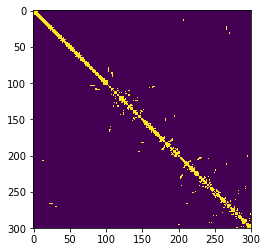

R15 (600, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


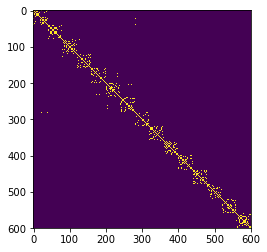

spiral (312, 2)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


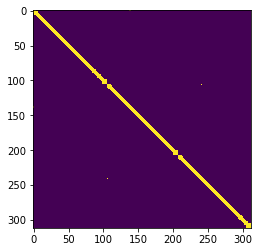

In [29]:
### simulated data
### p = 2
for dn in sim_data_names:
    (data,labels)  = cluster_data[dn]
    print(dn,data.shape )
    (initialization(data))

letter (20000, 16)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


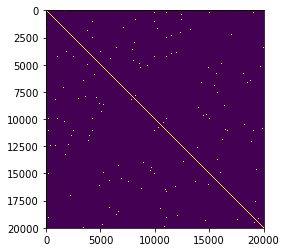

wine (178, 13)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


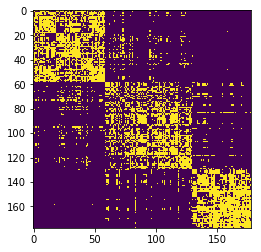

glass (214, 9)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


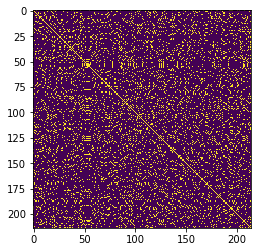

thyroid (215, 5)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


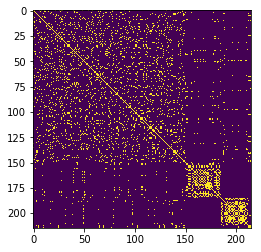

yeast (1484, 8)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


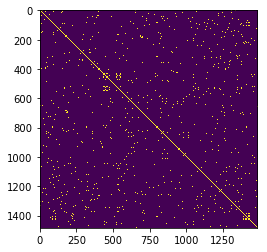

iris (150, 4)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


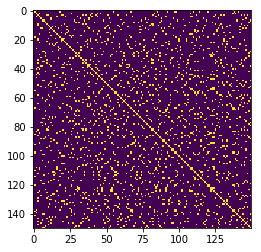

leaves (1600, 64)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


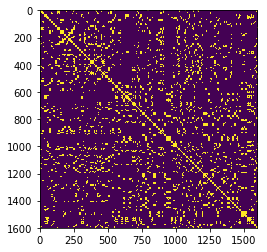

wdbc (569, 30)
Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


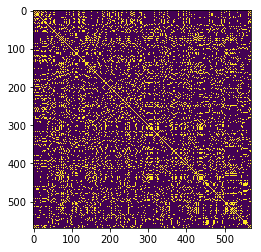

In [61]:
### real data
### p > 2
for dn in real_data_names:
    (data,labels)  = cluster_data[dn]
    print(dn,data.shape )
    (initialization(data))

It seems to me, for some of the real data, the n0 is too big. The weigh matrix was initilized with too many zeros. Will this cause some problems in the following iterations? Especially when performaing the chi square test.

### Wine data

In [92]:
#### Take a look the distance distribution
#### Use wine data as example

In [93]:
dn = 'wine'
(data,labels)  = cluster_data[dn]
print('data.shape',data.shape)
### p=13
### if use n0=2p+2=38, the h0 would be very big.
### test this below

data.shape (178, 13)


In [94]:
import scipy
from  scipy.spatial.distance import pdist,squareform
from scipy.spatial import distance_matrix


weight_matrix_history = []
(n_points,n_features) = data.shape
distance_matrix = scipy.spatial.distance_matrix(data,data)
weight_matrix = np.zeros(shape=(n_points,n_points))
weight_matrix_history.append((0,weight_matrix))
sorted_distance_idx_matrix = np.argsort(distance_matrix,axis=1)
sorted_distance_matrix = np.sort(distance_matrix,axis=1)

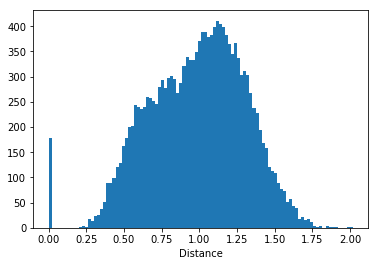

In [95]:
import matplotlib.pyplot as plt
plt.hist(distance_matrix[np.triu_indices(n_points)], bins=100)
plt.xlabel('Distance')
plt.show()

In [96]:
### each point needs at least n0 neighbors
n0 = 2*n_features+2
n0

28

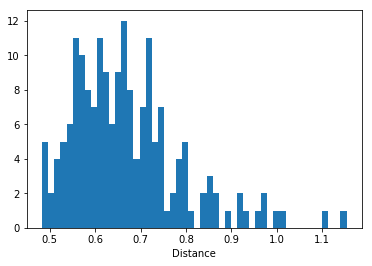

In [97]:
### radius such that each point has at least n0 neighbors
h0 = sorted_distance_matrix[:,n0]
plt.hist(h0, bins=50)
plt.xlabel('Distance')
plt.show()

In [98]:
max_h0 = np.reshape([np.maximum(h0[i],h0[j]) for i in range(n_points) for j in range(n_points)],newshape=(n_points,n_points))
#print('max_h0.shape',max_h0.shape)
### weight_matrix
weight_matrix = (distance_matrix <= max_h0).astype('int')

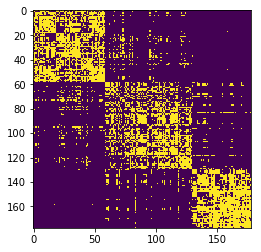

In [99]:
plot_weight_matrix(weight_matrix)
#plt.show()

### Weight matrix update

Check how the weight matrix is updated at each h_k

In [114]:
dn = 'wine'
(data,labels)  = cluster_data[dn]

Calculate distance matrix, done
Sort distance matrix, done
Initialize weight matrix, done


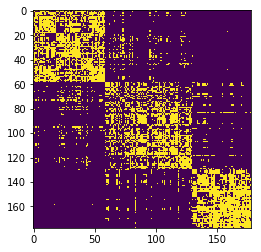

In [162]:
result = initialization(data)

h_k 1.1981658233
h_k 1.24993687267
h_k 1.2514869379
k= 0


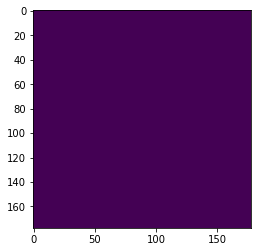

k= 1.15388885589


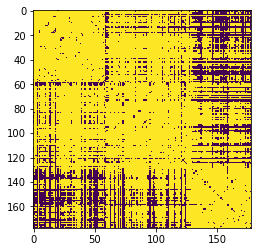

k= 1.1981658233


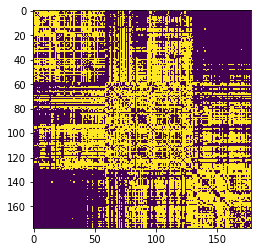

k= 1.24993687267


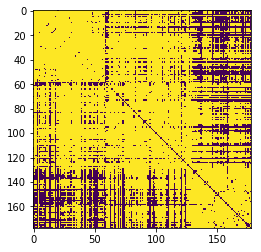

k= 1.2514869379


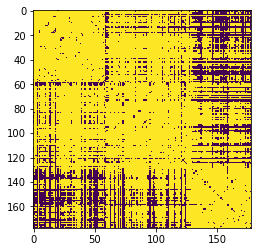

In [163]:
sys.path.append('../kmean_clustering')
from kmean_clustering import adaptive_cluster
result = adaptive_cluster(data, gap_par = 0.01, n0=None,debug=False)
for (k,weight_matrix) in result['weight_matrix_history']:
    print('k=',k)
    plot_weight_matrix(weight_matrix)

h_k 1.00084709905
h_k 1.02379809226
h_k 1.04748783752
h_k 1.08714065721
h_k 1.120235138
h_k 1.16070125732
h_k 1.20249396732
h_k 1.2514869379
k= 0


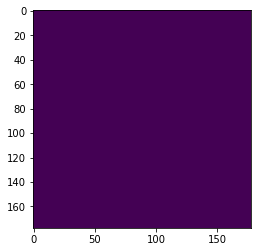

k= 0.97905223981


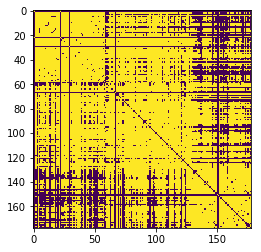

k= 1.00084709905


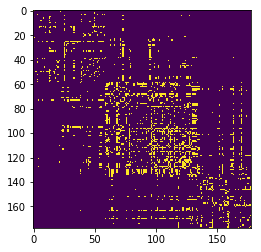

k= 1.02379809226


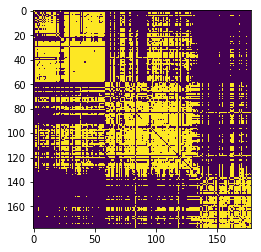

k= 1.04748783752


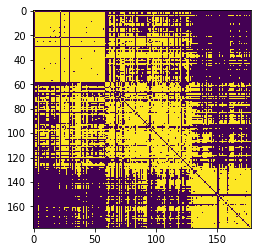

k= 1.08714065721


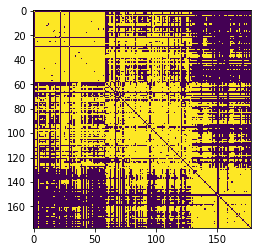

k= 1.120235138


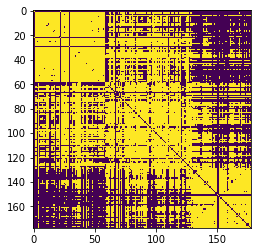

k= 1.16070125732


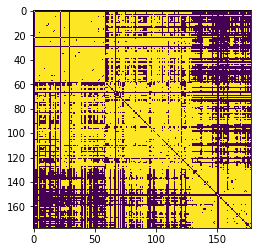

k= 1.20249396732


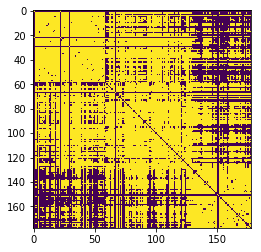

k= 1.2514869379


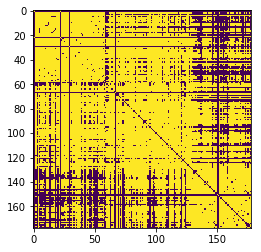

In [164]:
result = adaptive_cluster(data, gap_par = 0.01, n0=5,debug=False)
for (k,weight_matrix) in result['weight_matrix_history']:
    print('k=',k)
    plot_weight_matrix(weight_matrix)

Try  negative lambda.

h_k 1.00084709905
h_k 1.02379809226
h_k 1.04748783752
h_k 1.08714065721
h_k 1.120235138
h_k 1.16070125732
h_k 1.20249396732
h_k 1.2514869379
Number of clusters [  0.   1.   2.   3.   4.   5.   6.   7.  nan  nan  nan  nan  nan  nan  nan
  nan]
k= 0 S 0.0


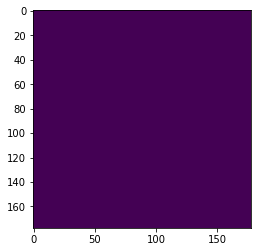

k= 0.97905223981 S 10540


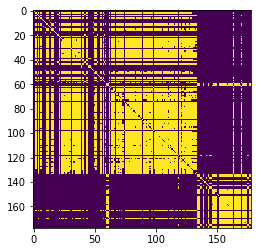

k= 1.00084709905 S 604


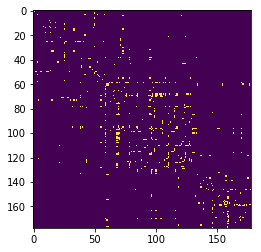

k= 1.02379809226 S 4271


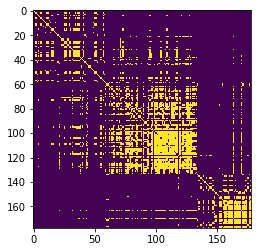

k= 1.04748783752 S 8022


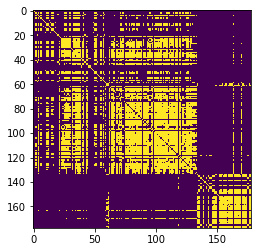

k= 1.08714065721 S 9032


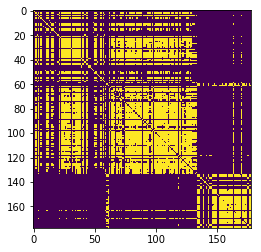

k= 1.120235138 S 9406


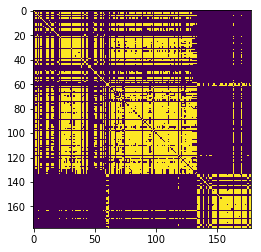

k= 1.16070125732 S 9830


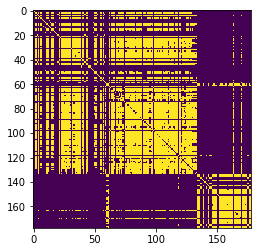

k= 1.20249396732 S 10188


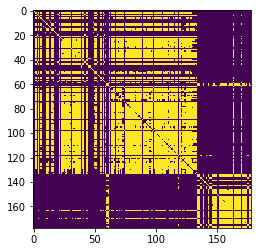

k= 1.2514869379 S 10540


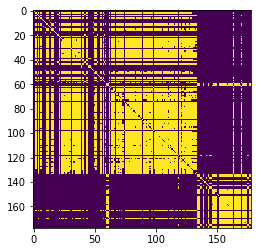

In [165]:
result = adaptive_cluster(data, gap_par = -0.1, n0=5,debug=False)
print('Number of clusters',np.unique(result['cluster_label']))
for (k,weight_matrix) in result['weight_matrix_history']:
    print('k=',k,'S',np.sum(weight_matrix))
    plot_weight_matrix(weight_matrix)

It looks much better with small lambda ( I tried  (-0.5,-0.2,-0.1,0,0.1) )

Conclusion: for real data (the p is relatively large), we need to use smaller n0 rather the one used in the paper and smaller lambda.